In [1]:
from pyNN.neuron import *
from pyNN.neuron import HH_cond_exp
from pyNN.neuron import EIF_cond_exp_isfa_ista
from pyNN.neuron import Izhikevich

from pyNN import neuron
#
from pyNN.neuron import simulator as sim
from pyNN.neuron import setup as setup

from pyNN.neuron import DCSource
from types import MethodType


/opt/conda/lib/python3.5/site-packages/pyNN/neuron/__init__.py:14: UserWarning: mpi4py not available
  warnings.warn("mpi4py not available")


In [2]:
import io
import math
import pdb
#from numba import jit
from contextlib import redirect_stdout
import numpy as np
#from .base import *
import quantities as qt
from quantities import mV, ms, s
import matplotlib.pyplot as plt
from pyNN.neuron import *
from pyNN.neuron import HH_cond_exp
from pyNN.neuron import EIF_cond_exp_isfa_ista
from pyNN.neuron import Izhikevich

from pyNN import neuron
#
from pyNN.neuron import simulator as sim
from pyNN.neuron import setup as setup
#from pyNN.neuron import Izhikevich
#from pyNN.neuron import Population
from pyNN.neuron import DCSource
import numpy as np
import copy
from neo import AnalogSignal
import neuronunit.capabilities.spike_functions as sf

import neuronunit.capabilities as cap
cap.ReceivesCurrent
cap.ProducesActionPotentials
def bind_NU_interface(model):

    def init_backend(self, attrs = None, cell_name = 'alice', current_src_name = 'hannah', DTC = None):
        backend = 'HHpyNN'
        self.current_src_name = current_src_name
        self.cell_name = cell_name
        self.adexp = True

        self.DCSource = DCSource
        self.setup = setup
        self.model_path = None
        self.related_data = {}
        self.lookup = {}
        self.attrs = {}
        self.neuron = neuron
        self.model._backend = self
        self.backend = self
        self.model.attrs = {}

        self.orig_lems_file_path = 'satisfying'
        self.model._backend.use_memory_cache = False
        #self.model.unpicklable += ['h','ns','_backend']

        if type(DTC) is not type(None):
            if type(DTC.attrs) is not type(None):

                self.set_attrs(**DTC.attrs)
                assert len(self.model.attrs.keys()) > 0

            if hasattr(DTC,'current_src_name'):
                self._current_src_name = DTC.current_src_name

            if hasattr(DTC,'cell_name'):
                self.cell_name = DTC.cell_name

    def get_membrane_potential(self):
        """Must return a neo.core.AnalogSignal.
        And must destroy the hoc vectors that comprise it.
        """
        #dt = float(copy.copy(self.neuron.dt))
        data = self.hhcell.get_data().segments[0]
        return data.filter(name="v")[0]

    def _local_run(self):
        '''
        pyNN lazy array demands a minimum population size of 3. Why is that.
        '''
        results = {}
        DURATION = 1000.0
        self.neuron.record_v(self.hhcell, "Results/HH_cond_exp_%s.v" % str(neuron))
        #self.neuron.record_gsyn(self.hhcell, "Results/HH_cond_exp_%s.gsyn" % str(neuron))
        self.neuron.run(DURATION)
        data = self.hhcell.get_data().segments[0]
        volts = data.filter(name="v")[0]#/10.0

        vm = AnalogSignal(volts,
                     units = mV,
                     sampling_period = self.dt *ms)
        results['vm'] = vm
        results['t'] = vm.times # self.times
        results['run_number'] = results.get('run_number',0) + 1
        return results


    def load_model(self):
        self.hhcell = neuron.create(EIF_cond_exp_isfa_ista())
        neuron.setup(timestep=0.01, min_delay=1.0)



    def set_attrs(self,**attrs):
        self.init_backend()
        self.model.attrs.update(attrs)
        assert type(self.model.attrs) is not type(None)
        self.hhcell[0].set_parameters(**attrs)
        return self


    def inject_square_current(self,current):
        attrs = copy.copy(self.model.attrs)
        self.init_backend()
        self.set_attrs(**attrs)
        c = copy.copy(current)
        if 'injected_square_current' in c.keys():
            c = current['injected_square_current']

        stop = float(c['delay'])+float(c['duration'])
        duration = float(c['duration'])
        start = float(c['delay'])
        amplitude = float(c['amplitude'])
        electrode = self.neuron.DCSource(start=start, stop=stop, amplitude=amplitude)
        delay = float(c['delay'])#/dt#.rescale('ms')
        tmax = delay + duration + 200.0#/dt#*pq.ms
        tmin = 0.0
        self.times = np.linspace(tmin, tmax, 10000)
        self.dt = self.times[1]-self.times[0]


        electrode.inject_into(self.hhcell)
        self.results = self._local_run()
        self.vm = self.results['vm']

    def get_APs(self, **run_params):
        vm = self.get_membrane_potential()
        print(vm)
        waveforms = sf.get_spike_waveforms(vm)
        return waveforms

    def get_spike_train(self, **run_params):
        vm = self.get_membrane_potential(**run_params)
        spike_train = sf.get_spike_train(vm)
        return spike_train
    
    def get_spike_count(self, **run_params):
        vm = self.get_membrane_potential(**run_params)
        print(sf.get_spike_train(vm))
        print(len(sf.get_spike_train(vm)))
        return len(sf.get_spike_train(vm))
    
    model.init_backend = MethodType(init_backend,model)
    model.get_spike_count = MethodType(get_spike_count,model)
    model.get_APs = MethodType(get_APs,model)
    model.get_spike_train = MethodType(get_spike_train,model)
    model.set_attrs = MethodType(set_attrs, model) # Bind to the score.
    model.inject_square_current = MethodType(inject_square_current, model) # Bind to the score.
    model.set_attrs = MethodType(set_attrs, model) # Bind to the score.
    model.get_membrane_potential = MethodType(get_membrane_potential,model)
    model.load_model = MethodType(load_model, model) # Bind to the score.
    model._local_run = MethodType(_local_run,model)
    model.init_backend(model)
    model.load_model() #= MethodType(load_model, model) # Bind to the score.

    return model
HH_cond_exp = bind_NU_interface(HH_cond_exp)    
#HH_cond_exp

In [3]:
electro_tests = []
obs_frame = {}
test_frame = {}
import os
import pickle
try: 

    electro_path = str(os.getcwd())+'all_tests.p'

    assert os.path.isfile(electro_path) == True
    with open(electro_path,'rb') as f:
        (obs_frame,test_frame) = pickle.load(f)

except:
    for p in pipe:
        p_tests, p_observations = get_neab.get_neuron_criteria(p)
        obs_frame[p["name"]] = p_observations#, p_tests))
        test_frame[p["name"]] = p_tests#, p_tests))
    electro_path = str(os.getcwd())+'all_tests.p'
    with open(electro_path,'wb') as f:
        pickle.dump((obs_frame,test_frame),f)

In [4]:
use_test = test_frame["Neocortex pyramidal cell layer 5-6"]
use_test[0].observation
#from neuronunit.tests import RheobaseP
from neuronunit.tests.fi import RheobaseTest# as discovery

rtp = RheobaseTest(use_test[0].observation)
use_test[0] = rtp

INFO:PyNN:Initializing membrane potential of 0 cells and 0 Populations.


[[-65.        ]
 [-65.00597081]
 [-65.01193532]
 ..., 
 [-70.59810423]
 [-70.59810422]
 [-70.59810421]] mV


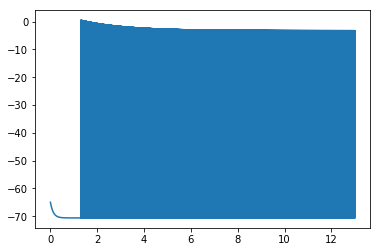

[[-65.        ]
 [-65.00597081]
 [-65.01193532]
 ..., 
 [-73.60668399]
 [-73.60644513]
 [-73.60620628]] mV


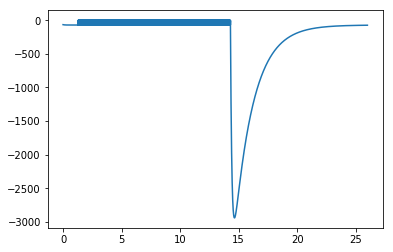

In [5]:
#dir(HH_cond_exp)
#HH_cond_exp.get_parameters()
#hhcell[0].get_parameters()
#dir(HH_cond_exp)
import quantities as pq
HH_cond_exp.attrs = HH_cond_exp.simple_parameters(HH_cond_exp)
#use_test[0].generate_prediction(HH_cond_exp)
iparams = {}
iparams['injected_square_current'] = {}
#iparams['injected_square_current']['amplitude'] = 1.98156805*pq.pA
iparams['injected_square_current']['amplitude'] = 2000.98156805*pq.pA

DELAY = 100.0*pq.ms
DURATION = 1000.0*pq.ms
iparams['injected_square_current']['delay'] = DELAY
iparams['injected_square_current']['duration'] = int(DURATION)

HH_cond_exp.inject_square_current(iparams)

print(HH_cond_exp.vm)

import matplotlib.pyplot as plt
plt.plot(HH_cond_exp.vm.times,HH_cond_exp.vm)


plt.show()
iparams['injected_square_current']['amplitude'] = 1.98156805*pq.pA
#iparams['injected_square_current']['amplitude'] = 2000.98156805*pq.pA

DELAY = 100.0*pq.ms
DURATION = 1000.0*pq.ms
iparams['injected_square_current']['delay'] = DELAY
iparams['injected_square_current']['duration'] = int(DURATION)

HH_cond_exp.inject_square_current(iparams)

print(HH_cond_exp.vm)

import matplotlib.pyplot as plt
plt.plot(HH_cond_exp.vm.times,HH_cond_exp.vm)

plt.show()